<font size=8> F-I curve test

In [9]:
#Common Python Packages
from pickle import TRUE
import time
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + '/..')

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

#my imports
from adaptation import pc_single,ff
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "time_constant_tests")


In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [12]:
neuron_config=neuron_configs_bio.config()
neuron_config['input_type']='DC'
neuron_config['DC_Latches']=True
neuron_config['DC_FI_Range']=np.linspace(0,250,15,dtype=int)
neuron_config['DC_Coarse']=5

#the lower the refreactor paramater the more slanted and curving  the fi curve is
neuron_config['PC_GAIN']=[0,30]
neuron_config['PC_REF']=[1,70]
neuron_config['PC_SPK_THR']=[4,100]

neuron_config['PV_GAIN']=[1,70]
neuron_config['PV_REF']=[1,200]
neuron_config['PV_SPK_THR']=[5,250]

neuron_config['SST_GAIN']=[1,80]
neuron_config['SST_REF']=[1,90]
neuron_config['SST_SPK_THR']=[5,250]


In [ ]:
[FF_output,test_config]=ff.ff_single_neurons(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
data_path='/home/hector/Documents/dynapse-se2-data/time_constant_tests/'
np.save(data_path+'FF_output_1.npy',FF_output)

28.003296237907062


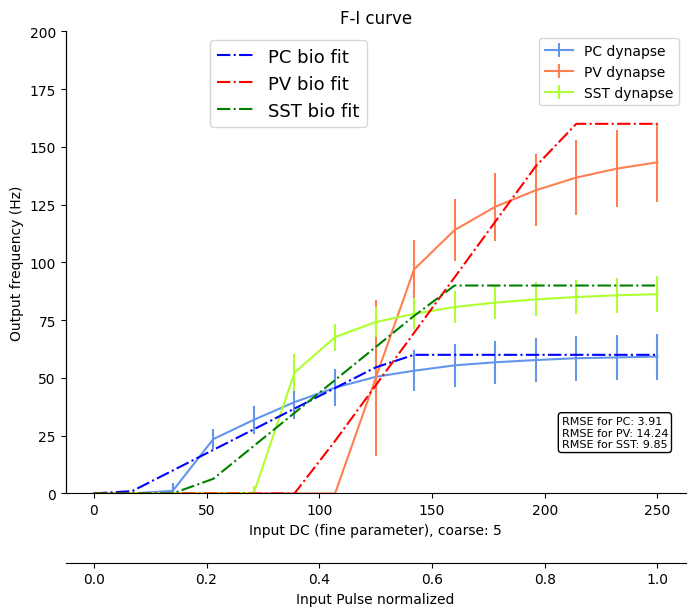

In [13]:
# Load your data

FF_output = np.load(data_type_path+'/FF_output.npy', allow_pickle=True)
rmse_PC,rmse_PV,rmse_SST=Fit_FI_Curves(FF_output,neuron_config,max_val=250/250,plot=True)

print(rmse_PC+rmse_PV+rmse_SST)

In [5]:
import json
from scipy.optimize import differential_evolution

# load initial guess of parameters, also includes others
neuron_config = neuron_configs()

# parameters to tune 
param_bounds = {
    'PC_GAIN': [0,200],
    'PC_REF': [0,200],
    'PC_SPK_THR': [0,200],
    'PV_GAIN': [0,200],
    'PV_REF': [0,200],
    'PV_SPK_THR': [0,200],
    'SST_GAIN': [0,200],
    'SST_REF': [0,200],
    'SST_SPK_THR': [0,200]
}

neuron_config['DC_FI_Range']=np.linspace(0,250,20,dtype=int)
bounds = list(param_bounds.values())

# Load the best parameters from a previous run, if they exist
try:
    with open('best_parameters.json', 'r') as f:
        best_parameters = json.load(f)
except FileNotFoundError:
    best_parameters = None

best_score = float('inf')

# Function to minimize
def objective(params):
    global best_parameters
    global best_score

    # Round parameters to ensure they are integers
    params = [round(p) for p in params]

    for i, key in enumerate(param_bounds.keys()):
        if isinstance(neuron_config[key], list):
            neuron_config[key][1] = params[i]  # We only update the second value

    FF_output = ff.ff_single_neurons(board=board, profile_path=profile_path, number_of_chips=number_of_chips, neuron_config=neuron_config)
    rmse_PC,rmse_PV,rmse_SST = Fit_FI_Curves(FF_output, neuron_config, max_val=250/250, plot=False)
    
    score = rmse_PC + rmse_PV + rmse_SST

    # Update the best parameters if the new score is lower
    if score < best_score:
        best_score = score
        best_parameters = {k: v for k, v in zip(param_bounds.keys(), params)}

    return score

try:
    # Perform optimization
    result = differential_evolution(objective, bounds, strategy='best1bin', popsize=15, mutation=(0.5, 1.0), recombination=0.7, tol=0.01, seed=42)

    # Output the results
    print('Final Parameters:')
    for i, key in enumerate(param_bounds.keys()):
        print(f'{key}: {result.x[i]}')

except KeyboardInterrupt:
    print('Optimization process interrupted.')

except Exception as e:
    print('An error occurred during optimization:', e)
    
finally:
    if best_parameters is not None:
        print('Best trial so far:')
        for key, value in best_parameters.items():
            print(f'{key}: {value}')
        print(f'Best score: {best_score}')

        # Save the best parameters for the next run
        with open('best_parameters.json', 'w') as f:
            json.dump(best_parameters, f)


Setting Latches
Setting monitors
250 250 250


PC Neurons

[221, 235, 239, 255, 201, 211, 223, 230, 252, 253, 237, 234, 236, 250, 169, 180, 183, 189, 204, 227, 242, 188, 194, 207, 248, 251, 203, 215, 219, 228, 196, 165, 171, 181, 195, 220, 222, 244, 149, 156, 164, 179, 205, 206, 217, 226, 238, 254, 148, 157, 158, 210, 214, 232, 245, 246, 131, 152, 161, 163, 167, 173, 176, 198, 200, 209, 231, 233, 113, 146, 170, 190, 192, 197, 229, 247, 249, 115, 118, 139, 141, 143, 159, 160, 166, 186, 202, 213, 218, 107, 134, 151, 155, 162, 177, 191, 216, 225, 243, 116, 126, 130, 140, 145, 168, 175, 182, 185, 187, 224, 129, 147, 150, 172, 241, 70, 114, 121, 132, 178, 212, 100, 119, 124, 133, 174, 199, 84, 108, 120, 125, 137, 154, 240, 98, 101, 135, 142, 184, 193, 68, 85, 112, 138, 67, 128, 99, 106, 109, 117, 122, 123, 136, 153, 66, 69, 71, 86, 88, 97, 102, 144, 208, 56, 77, 93, 111, 38, 50, 74, 81, 83, 51, 53, 65, 73, 79, 87, 91, 127, 27, 54, 72, 90, 94, 103, 104, 105, 20, 37, 39, 59, 64, 75, 96, 19, 2

<font size=7> Now with the synapse


In [18]:
neuron_config=neuron_configs()


neuron_config['input_type']='Regular'
neuron_config['DC_Latches']=False
neuron_config['Adaptation']=False
neuron_config['Freq_FI_Range']=np.linspace(0,200,10,dtype=int)
#the lower the refreactor paramater the more slanted and curving  the fi curve is
neuron_config['PC_GAIN']=[0,30]
neuron_config['PC_REF']=[1,70]
neuron_config['PC_SPK_THR']=[4,100]

neuron_config['PV_GAIN']=[1,70]
neuron_config['PV_REF']=[1,200]
neuron_config['PV_SPK_THR']=[5,250]

neuron_config['SST_GAIN']=[1,80]
neuron_config['SST_REF']=[1,90]
neuron_config['SST_SPK_THR']=[5,250]

neuron_config['PC_W0']=[4,150]
neuron_config['PC_AMPA_GAIN']=[4,150]
neuron_config['PV_W0']=[3,100]
neuron_config['PV_AMPA_GAIN']=[5,150]
neuron_config['SST_W0']=[3,200]
neuron_config['SST_AMPA_GAIN']=[5,200]

[FF_output,test_config]=ff.ff_single_neurons(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
data_path='/home/hector/Documents/dynapse-se2-data/general_tests/'
np.save(data_path+'FF_syn_output.npy',FF_output)

Setting Latches
Setting monitors
250 250 250


PC Neurons

[221, 235, 239, 255, 201, 211, 223, 230, 252, 253, 237, 234, 236, 250, 169, 180, 183, 189, 204, 227, 242, 188, 194, 207, 248, 251, 203, 215, 219, 228, 196, 165, 171, 181, 195, 220, 222, 244, 149, 156, 164, 179, 205, 206, 217, 226, 238, 254, 148, 157, 158, 210, 214, 232, 245, 246, 131, 152, 161, 163, 167, 173, 176, 198, 200, 209, 231, 233, 113, 146, 170, 190, 192, 197, 229, 247, 249, 115, 118, 139, 141, 143, 159, 160, 166, 186, 202, 213, 218, 107, 134, 151, 155, 162, 177, 191, 216, 225, 243, 116, 126, 130, 140, 145, 168, 175, 182, 185, 187, 224, 129, 147, 150, 172, 241, 70, 114, 121, 132, 178, 212, 100, 119, 124, 133, 174, 199, 84, 108, 120, 125, 137, 154, 240, 98, 101, 135, 142, 184, 193, 68, 85, 112, 138, 67, 128, 99, 106, 109, 117, 122, 123, 136, 153, 66, 69, 71, 86, 88, 97, 102, 144, 208, 56, 77, 93, 111, 38, 50, 74, 81, 83, 51, 53, 65, 73, 79, 87, 91, 127, 27, 54, 72, 90, 94, 103, 104, 105, 20, 37, 39, 59, 64, 75, 96, 19, 2

KeyboardInterrupt: 

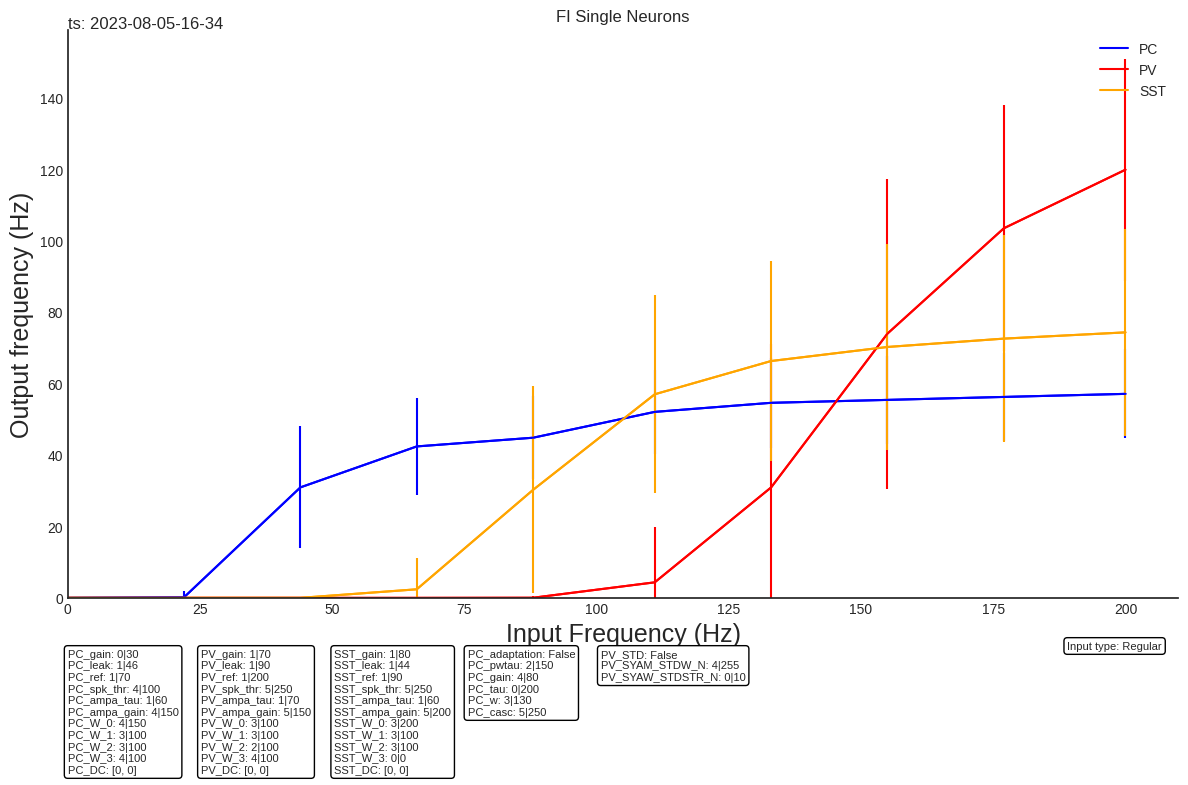

In [17]:
data_path='/home/hector/Documents/dynapse-se2-data/general_tests/'
FF_output=np.load(data_path+'FF_syn_output.npy',allow_pickle=True)
frequency_vs_input_plot(FF_output, test_config,neuron_config, annotate=True)